In [57]:
import numpy as np 
import pandas as pd 
from glob import glob 
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
images_path = "../input/flickr8k-sau/Flickr_Data/Images/"
images = glob(images_path+"*.jpg")
print(len(images))

8091


In [4]:
images[0]

'../input/flickr8k-sau/Flickr_Data/Images/3226254560_2f8ac147ea.jpg'

We will use the Resnet Model from Keras which is a pre-trained model to extract the features (objects) from the images

In [4]:
from  tensorflow.keras.applications import ResNet50

In [5]:
incept_model = ResNet50(include_top=True)

2021-09-21 23:26:44.841654: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-21 23:26:44.845323: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-21 23:26:44.891459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-21 23:26:44.892075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-21 23:26:44.892129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-21 23:26:44.926955: I tensorflow/stream_executor/platform/def

102973440/102967424 [==============================] - 1s 0us/step


In [6]:
incept_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
from tensorflow.keras.models import Model 
last_layer = incept_model.layers[-2].output
res_net_model = Model(inputs=incept_model.input,outputs=last_layer)

In [8]:
incept_model.input


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [9]:
res_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Pre processing the Data

we are going to read the data (images) from the files and for every image we will resize it to (224,224) to being able to fiting it to the ResNet50 model 

In [10]:
images_features = {}
count= 0
for image in images : 
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    img = img.reshape(1,224,224,3)
    predict = res_net_model.predict(img).reshape(2048,)
    image_name = image.split("/")[-1]
    images_features[image_name] = predict
    count +=1
    if count>1700: 
        break
    elif count % 50 == 0:
        print(count)
            
    

2021-09-21 23:26:56.114521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-21 23:26:56.128323: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz
2021-09-21 23:26:57.097477: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-21 23:27:02.334326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-21 23:27:03.051825: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700


Data Preprocess

In [14]:
captions_path = "../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

In [15]:
captions = pd.read_csv(captions_path,sep="\n",header=None)

In [16]:
captions = open(captions_path,"rb").read().decode('utf8').split("\n")

In [23]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [24]:
captions_dict = {}
for i in captions : 
    try : 
        img_name = i.split("\t")[0][:-2]
        caption  = i.split("\t")[1]
        if img_name in images_features: 
            if img_name not in captions_dict:
                # the case when the image name is not created yet
                captions_dict[img_name] = [caption]
            else : 
                # the case where the image name is created so we will juste append the new value knowing that there is 5 captions for every image
                captions_dict[img_name].append(caption)
    except:
        pass

Now we will add a StartOfStrinng and EndOfString Tokens to the sentences

In [20]:
def preprocessed(txt): 
    modified = txt.lower()
    modified = "startofseq" + modified + "endofseq"
    return modified

In [25]:
for k , v in captions_dict.items() : 
    for caption in v: 
        captions_dict[k][v.index(caption)] = preprocessed(caption)
        

Now will create our vocabulary, and for this we will the Tensorflow tokenizer

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [27]:
tokenizer = Tokenizer(oov_token="Other")

In [28]:
sentences = []
for k,v in captions_dict.items(): 
    for sentence in v: 
        sentences.append(sentence)

In [29]:
tokenizer.fit_on_texts(sentences)

In [30]:
count_words = tokenizer.word_index

In [31]:
sequences =  tokenizer.texts_to_sequences(sentences)

In [32]:
sequences_images = {}
for k,v in captions_dict.items(): 
    sequences_images[k] = sequences[:5]
    sequences = sequences[5:]
    

In [33]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
sequences =  tokenizer.texts_to_sequences(sentences)

In [35]:
MAX_LEN = np.max([len(x) for x in sequences])
MAX_LEN

33

In [36]:
VOCAB_SIZE = len(count_words)
def generator (photo , caption ): 
    X = []
    y_in = []
    y_out = []
    for k , v in caption.items(): 
        for sentence in v : 
            for i in range(1,len(sentence)): 
#                 this for iterate every word in the sentence
                X.append(photo[k])
                in_seq = [sentence[:i]]
                out_seq = [sentence[i]]    
                in_seq = pad_sequences(in_seq,maxlen=MAX_LEN,padding ="post" ,truncating="post")[0]
                out_seq = to_categorical([out_seq],num_classes=VOCAB_SIZE+1)[0]
                y_in.append(in_seq)
                y_out.append(out_seq)
        
    return X, y_in,y_out

In [37]:
X,y_in,y_out = generator(images_features,sequences_images)

In [38]:
X,y_in,y_out = np.array(X),np.array(y_in),np.array(y_out)

In [42]:
X.shape,y_in.shape,y_out.shape

((91704, 2048), (91704, 33), (91704, 4794))

# Creating the model


In [43]:
from tensorflow.keras.utils import to_categorical , plot_model 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint



In [44]:
MAX_LEN

33

In [45]:
embeding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words) +1
image_model = Sequential()
image_model.add(Dense(embeding_size,input_shape = (2048,),activation="relu"))
image_model.add(RepeatVector(max_len))
image_model.summary()

language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size,output_dim = embeding_size,input_length=max_len))
language_model.add( LSTM(256,return_sequences = True))
language_model.add(TimeDistributed(Dense(embeding_size)))
language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128,return_sequences = True)(conca)
x = LSTM(512,return_sequences = False)(x)
x = Dense(vocab_size)(x)
out = Activation("softmax")(x)
model = Model([image_model.input,language_model.input],outputs = out)
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 33, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 128)           613632    
_________________________________________________________________
lstm (LSTM)                  (None, 33, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 33, 128)           32896     
Total params: 1,040,768
Trai

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 33)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 128)      613632      embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
____________________________________________________________________________________________

In [50]:
model.fit([X, y_in], y_out, batch_size=256, epochs=50)


Epoch 1/50
  1/359 [..............................] - ETA: 19s - loss: 0.8807 - accuracy: 0.7773

2021-09-22 00:00:42.748264: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1758515904 exceeds 10% of free system memory.


359/359 [==============================] - 14s 39ms/step - loss: 1.0094 - accuracy: 0.7034
Epoch 2/50
359/359 [==============================] - 14s 40ms/step - loss: 0.9595 - accuracy: 0.7148
Epoch 3/50
359/359 [==============================] - 14s 39ms/step - loss: 0.9232 - accuracy: 0.7251
Epoch 4/50
359/359 [==============================] - 14s 40ms/step - loss: 0.8875 - accuracy: 0.7345
Epoch 5/50
359/359 [==============================] - 14s 40ms/step - loss: 0.8592 - accuracy: 0.7403
Epoch 6/50
359/359 [==============================] - 14s 40ms/step - loss: 0.8257 - accuracy: 0.7521
Epoch 7/50
359/359 [==============================] - 14s 39ms/step - loss: 0.7983 - accuracy: 0.7576
Epoch 8/50
359/359 [==============================] - 14s 39ms/step - loss: 0.7694 - accuracy: 0.7663
Epoch 9/50
359/359 [==============================] - 14s 39ms/step - loss: 0.7431 - accuracy: 0.7744
Epoch 10/50
359/359 [==============================] - 14s 39ms/step - loss: 0.7187 - accurac

As we can see, after 100 epochs we had an accuracy of 88.76% on the training set. Not bed for juste a 100 of epochs and 1700 images

> Note : we are not able to work with more data because we had a limited resources.

# Testing the model 

Now we will choose a random image and predict it's caption

In [55]:
def getImage(x): 
    test_img_path = images[x]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, (224,224))
    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

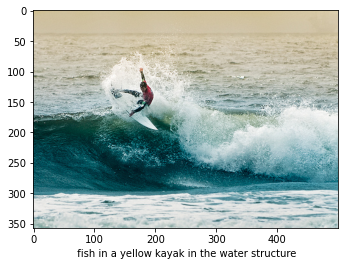

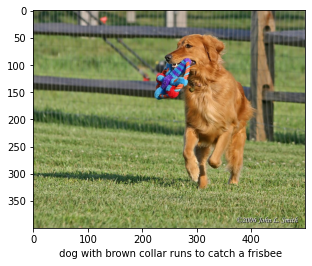

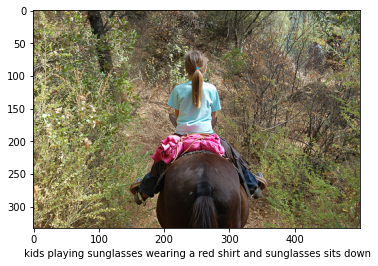

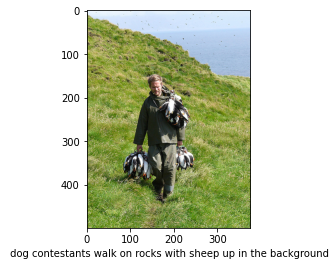

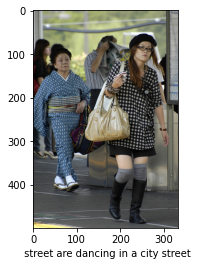

In [62]:
for i in range(5):
    # getting a random image
    no = np.random.randint(1500,7000,(1,1))[0,0]
    # extracting the features from the ResNet model
    test_feature = res_net_model.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1
        encoded = tokenizer.texts_to_sequences(text_inp)
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        for k,v in tokenizer.word_index.items():
            if v == prediction:
                sampled_word = k
                break
                
                
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        
        text_inp[0] += ' ' + sampled_word
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)